# AIPI 590 - XAI | Assignment #3
### Hongxuan Li

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/h0ngxuanli/AIPI590-XAI/blob/main/assignment1/adversarial_patch.ipynb)

#### References

- Telco Customer Churn Dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code
- Assumption check is assisted by ChatGPT-o1
- GAM is implemented by ChatGPT-o1

In [3]:
# import os

# # Remove Colab default sample_data
# !rm -r ./sample_data

# # Clone GitHub files to colab workspace
# repo_name = "/content/AIPI590-XAI" # Change to your repo name
# git_path = 'https://github.com/h0ngxuanli/AIPI590-XAI.git' #Change to your path
# !git clone "{git_path}"


# # Install dependencies from requirements.txt file
# !pip install -r "{os.path.join(repo_name,'assignment3/requirements.txt')}" #Add if using requirements.txt

# # Change working directory to location of notebook
# notebook_dir = 'assignment3/'
# path_to_notebook = os.path.join(repo_name,notebook_dir)
# %cd "{path_to_notebook}"
# %ls


rm: ./sample_data: No such file or directory
fatal: destination path 'AIPI590-XAI' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/AIPI590-XAI/assignment3/requirements.txt'
[Errno 2] No such file or directory: '/content/AIPI590-XAI/assignment3/'
/Users/lihongxuan/Desktop/AIPI/Courses/AIPI590-XAI/AIPI590-XAI/assignment3
AIPI590-XAI/                 interpretable_ml.ipynb
data/                        requirements.txt
interpretable_ml copy.ipynb


# Content

- [AIPI 590 - XAI | Assignment #3](#aipi-590---xai-|-assignment-#3)
    - [Hongxuan Li](#hongxuan-li)
      - [References](#references)
- [Content](#content)
- [Dependencies](#dependencies)
- [Load Data](#load-data)
- [EDA](#eda)
    - [Clean data and Label-encoding categorical data](#clean-data-and-label-encoding-categorical-data)
    - [Illustrate label distribution of categorical columns](#illustrate-label-distribution-of-categorical-columns)
  - [Examine Assumption Compliance](#examine-assumption-compliance)
    - [Linearity](#linearity)
    - [Check Autocorrelation](#check-autocorrelation)
    - [Check Homoscedasticity](#check-homoscedasticity)
    - [Normality of Residuals](#normality-of-residuals)
    - [Multicolinearity Check](#multicolinearity-check)
    - [Correct Specification Check](#correct-specification-check)
- [Model Training](#model-training)
    - [Normalize Features for Model Training](#normalize-features-for-model-training)
    - [Linear Regression Model](#linear-regression-model)
    - [Logistic Regression Model](#logistic-regression-model)
    - [Generalized Additive Model (GAM) Model](#generalized-additive-model-(gam)-model)
- [Performance and Interpretability Comparsion](#performance-and-interpretability-comparsion)
    - [Fit model on training data](#fit-model-on-training-data)
    - [Evaluation model performance on test data](#evaluation-model-performance-on-test-data)
    - [Evaluate model explanability](#evaluate-model-explanability)
- [Model Analysis](#model-analysis)
    - [Pros and Cons for each model](#pros-and-cons-for-each-model)
    - [Recommendations for the company](#recommendations-for-the-company)

# Dependencies

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
from scipy.interpolate import BSpline
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Ignore all warnings
warnings.filterwarnings('ignore')

# Load Data

In [8]:
df = pd.read_csv("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = df.drop(['customerID'], axis=1)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


# EDA

### Clean data and Label-encoding categorical data

In [11]:
categorical_columns = df.select_dtypes(include=['object','category']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int','float']).columns.tolist()
print("There are {} numerical columns and {} categorical columns".format(len(numerical_columns),len(categorical_columns)))

There are 3 numerical columns and 17 categorical columns


In [12]:
# missing value check
print(df.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [13]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [14]:
# examine unique values for each categorical column
for col in categorical_columns:
    print(f"Unique values in '{col}':")
    print(df[col].unique())

Unique values in 'gender':
['Female' 'Male']
Unique values in 'Partner':
['Yes' 'No']
Unique values in 'Dependents':
['No' 'Yes']
Unique values in 'PhoneService':
['No' 'Yes']
Unique values in 'MultipleLines':
['No phone service' 'No' 'Yes']
Unique values in 'InternetService':
['DSL' 'Fiber optic' 'No']
Unique values in 'OnlineSecurity':
['No' 'Yes' 'No internet service']
Unique values in 'OnlineBackup':
['Yes' 'No' 'No internet service']
Unique values in 'DeviceProtection':
['No' 'Yes' 'No internet service']
Unique values in 'TechSupport':
['No' 'Yes' 'No internet service']
Unique values in 'StreamingTV':
['No' 'Yes' 'No internet service']
Unique values in 'StreamingMovies':
['No' 'Yes' 'No internet service']
Unique values in 'Contract':
['Month-to-month' 'One year' 'Two year']
Unique values in 'PaperlessBilling':
['Yes' 'No']
Unique values in 'PaymentMethod':
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Unique values in 'TotalCharges':
['

In [15]:
# found that TotalCharges are not numeric
# convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# delete data with missing TotalCharges values
df = df.dropna()
del categorical_columns[-2]

In [16]:
# replace other values with 'No', and conduct label encoding
columns = ["Partner", "Dependents", "PhoneService", "OnlineSecurity", 'Partner', 'Dependents',
           "OnlineBackup", "DeviceProtection", "TechSupport", 'MultipleLines', 'PhoneService',
           "StreamingTV", "StreamingMovies", "PaperlessBilling", "Churn", 'PaperlessBilling']

for col in columns:
    df[col].replace(['No phone service', 'No internet service'], 'No', inplace=True)
    df[col].replace('Yes', 1, inplace=True)
    df[col].replace('No', 0, inplace=True)


In [17]:
# label encoding for other categorical columns
columns = ["Contract", "PaymentMethod", "InternetService", 'gender']
label_encoder = LabelEncoder()
for col in columns:
    df[col] = label_encoder.fit_transform(df[col])
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,0,0,1,0,1,1,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,0,1,0,1,1,1,1,1,1,3,84.80,1990.50,0
7039,0,0,1,1,72,1,1,1,0,1,1,0,1,1,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,0,0,1,0,0,0,0,0,0,1,2,29.60,346.45,0
7041,1,1,1,0,4,1,1,1,0,0,0,0,0,0,0,1,3,74.40,306.60,1


### Illustrate label distribution of categorical columns

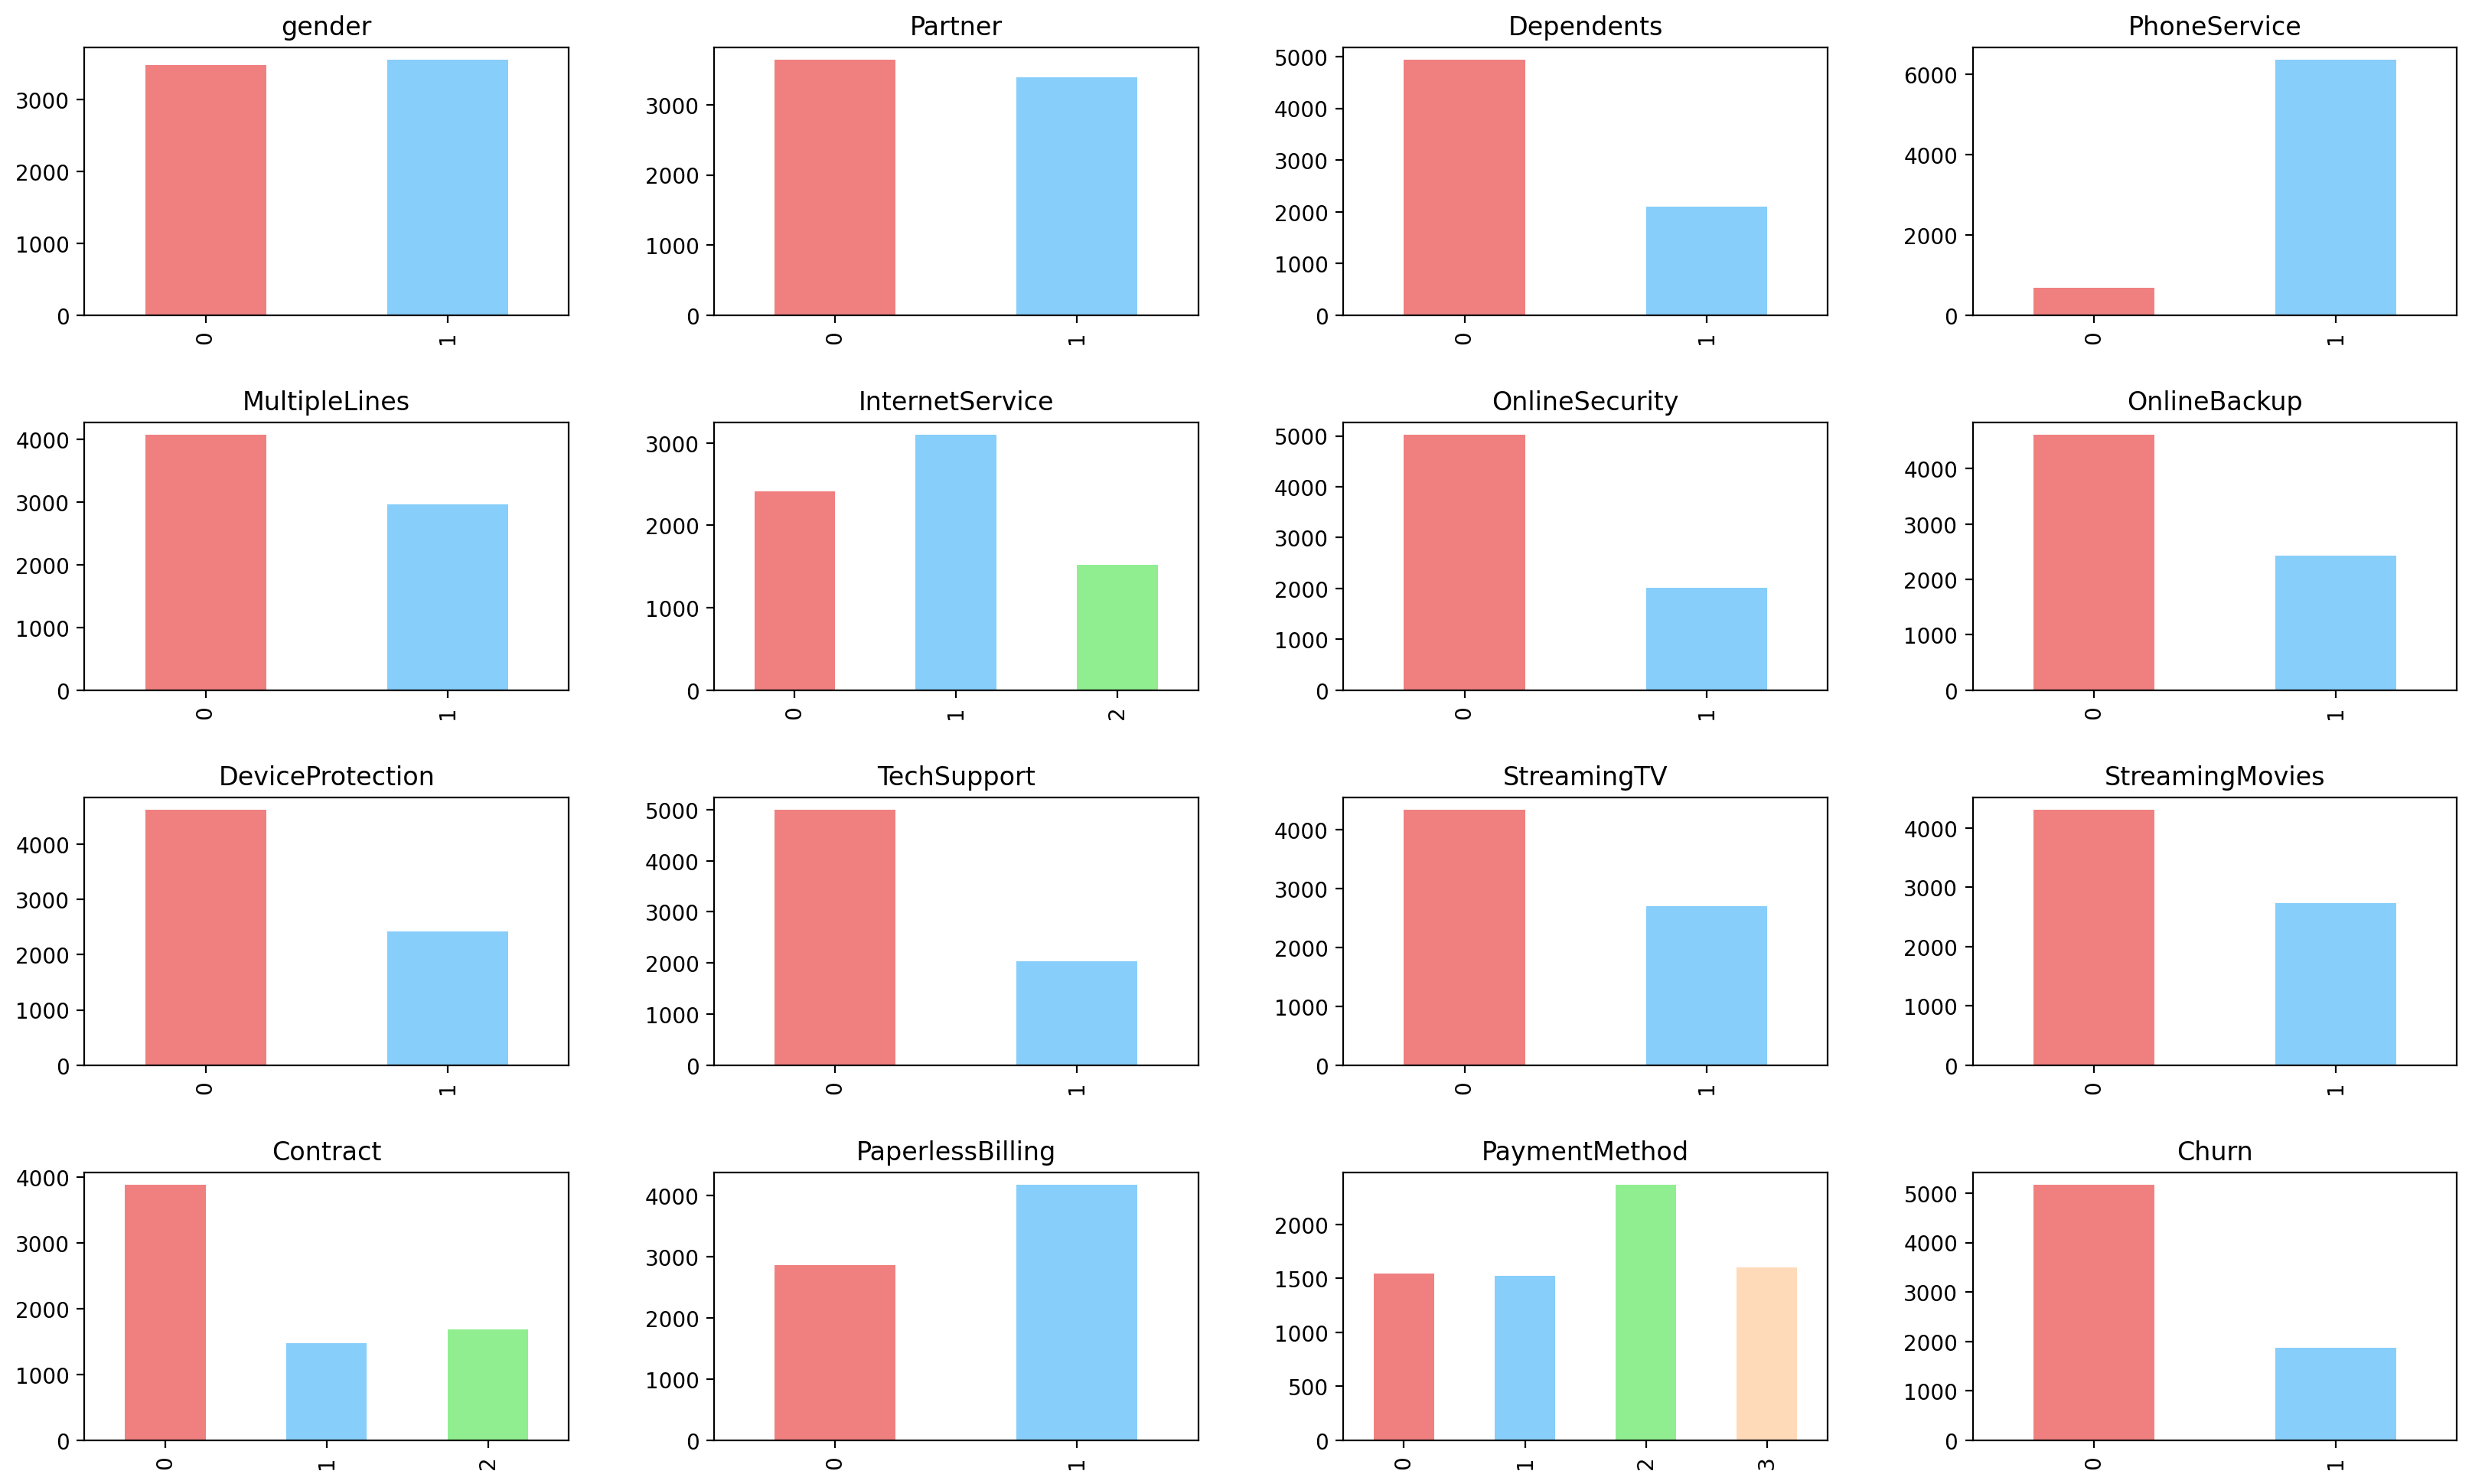

In [19]:
# Define lighter colors for the labels 0, 1, 2, 3
colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'peachpuff']

fig, axes = plt.subplots(5, 4, figsize=(20, 15), dpi = 200)
axes = axes.flatten() 

for i, col in enumerate(categorical_columns):
    value_counts = df[col].value_counts().sort_index()
    value_counts.plot(kind='bar', ax=axes[i], color=[colors[int(val)] for val in value_counts.index])
    axes[i].set_title(f'{col}')
    axes[i].set_xticks(list(range(len(value_counts.index))))  # Set x-ticks
    axes[i].set_xlabel('')  # Remove x-label
for j in range(16, len(axes)):
    fig.delaxes(axes[j])
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

## Examine Assumption Compliance

In [21]:
# define feature and target label column
target = 'Churn'
features = df.columns.tolist()
features.remove(target)
features, target

(['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'TotalCharges'],
 'Churn')

### Linearity
Explanation: 
- rare features linearly correlate with target label `Churn`
- `MonthlyCharges` linearly correlates with `StreamingTV`, `StreamingMoives`, `TotalCharges`
- `tenure` linearly correlates with `TotalCharges`, `Contract`

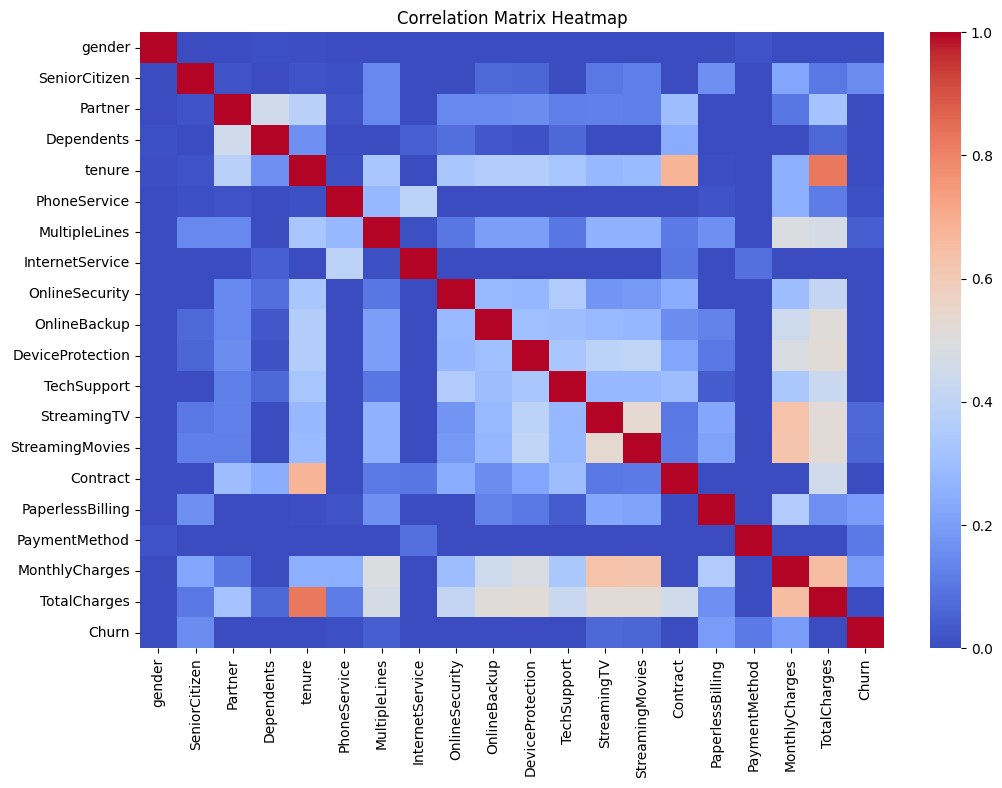

In [23]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Generate a heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()


### Check Autocorrelation
Explanation: 
- the Durbin-Watson score is around 2, which means no autocorrelation.

In [25]:
# feature columns and label columns
X = df.drop(columns=['Churn'])
y = df['Churn']
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()

# Compute the Durbin-Watson statistic for autocorrelation in the residuals
dw_stat = sm.stats.durbin_watson(model.resid)
print(f"Durbin-Watson statistic: {dw_stat}")


Durbin-Watson statistic: 2.003371879091953


### Check Homoscedasticity
Explanation: 
- the residuals are not randomly scattered around zero, showing heteroscedasticity

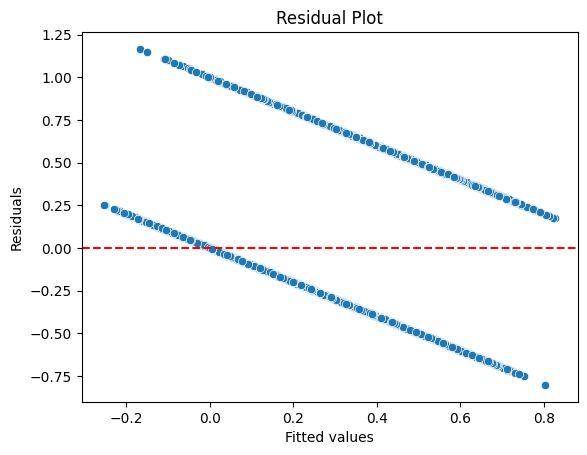

In [27]:
# Residual plot
residuals = model.resid
fitted_values = model.fittedvalues

sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Normality of Residuals
Explanation:
- there are some deviations from the line, suggesting the residuals are not normally distributed
- p-value < 0.05, which reject sthe null hypothesis that residuals are normally distributed.

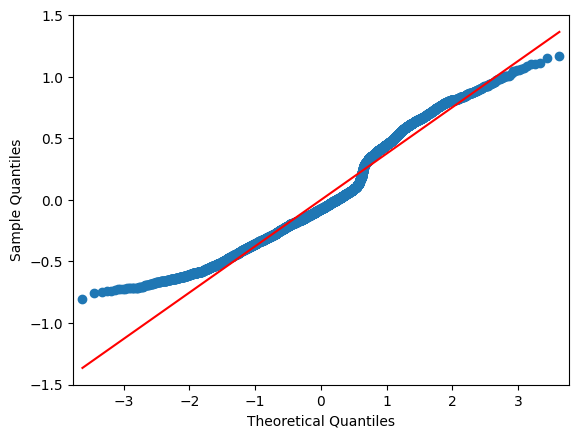

Shapiro-Wilk Test: Statistic=0.9584718942642212, p-value=8.818791625535371e-41


In [29]:
# Q-Q plot
sm.qqplot(residuals, line='s')
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

### Multicolinearity Check
Explanation: 
- VIF values above 5 indicate high multicollinearity, suggesting that some features are highly correlated.

In [31]:
# Calculate the Variance Inflation Factor
X_const = X_const.drop("const", axis = 1)
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif['Feature'] = X_const.columns
print(vif)


high_vif_features = vif[vif['VIF'] > 5]
if not high_vif_features.empty:
    print(f"Features with high multicollinearity (VIF > 5): {high_vif_features['Feature'].tolist()}")
else:
    print("No significant multicollinearity detected.")


          VIF           Feature
0    1.954551            gender
1    1.370495     SeniorCitizen
2    2.817809           Partner
3    1.955454        Dependents
4   14.708864            tenure
5   15.912037      PhoneService
6    2.609365     MultipleLines
7    4.422747   InternetService
8    2.059990    OnlineSecurity
9    2.300240      OnlineBackup
10   2.416963  DeviceProtection
11   2.142546       TechSupport
12   3.146653       StreamingTV
13   3.180417   StreamingMovies
14   4.193778          Contract
15   2.879116  PaperlessBilling
16   3.064495     PaymentMethod
17  28.751564    MonthlyCharges
18  14.870258      TotalCharges
Features with high multicollinearity (VIF > 5): ['tenure', 'PhoneService', 'MonthlyCharges', 'TotalCharges']


### Correct Specification Check
Explanation:
- A p-value below 0.05 from Ramsey RESET test suggests the model is misspecified

In [33]:
# Check for omitted variable bias (use Ramsey RESET test)
reset_test = sm.stats.linear_reset(model, use_f=True)
print(f"RESET test: Statistic={reset_test.statistic}, p-value={reset_test.pvalue}")


RESET test: Statistic=127.95038096578737, p-value=2.6429493487828787e-55


# Model Training

### Normalize Features for Model Training

In [36]:
# Standardizing the continuous features
scaler = StandardScaler()
df[['MonthlyCharges', 'TotalCharges', "tenure"]] = scaler.fit_transform(df[['MonthlyCharges', 'TotalCharges', "tenure"]])

In [37]:
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Linear Regression Model


- Initialization
    - Initialize `coef` and `intercept`

- Optimal Parameter
    - $ \boldsymbol{\hat{\beta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} $
        - $\mathbf{X}$ is added with a column of ones
        - $\hat{\boldsymbol{\beta}}$ includes the intercept as its first element
- Prediction
    - $ \hat{\mathbf{y}} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{b} $



In [39]:
class LinearRegression:
    def __init__(self):
        self.coef = None      # coefficients
        self.intercept = None # intercept

    def fit(self, X, y):
        # add a column of ones to X for the bias term
        X_b = np.c_[np.ones((X.shape[0], 1)), X]

        # derive the optimal coefficients
        w_hat = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

        # get coef and bias
        self.intercept = w_hat[0]
        self.coef = w_hat[1:]

    def predict(self, X):
        # get prediction
        pred = X.dot(self.coef) + self.intercept
        return pred


### Logistic Regression Model



- Initialize learning rate $\alpha$
- Sigmoid Function

    - $\sigma(\mathbf{z}) = \frac{1}{1 + e^{-\mathbf{z}}}$


- Training

    - For each iteration:

        - $\mathbf{z} = \mathbf{X}\boldsymbol{\beta} + \mathbf{b}$
        - $\hat{\mathbf{y}} = \sigma(\mathbf{z})$
- Update:

    - $\boldsymbol{\beta} := \boldsymbol{\beta} - \alpha \nabla_{\boldsymbol{\beta}}$
    - $\mathbf{b} := \mathbf{b} - \alpha \nabla_{\mathbf{b}}$
        - $\nabla_{\boldsymbol{\beta}} = \mathbf{X}^T (\hat{\mathbf{y}} - \mathbf{y})$
        - $\nabla_{\mathbf{b}} =  \mathbf{1}^T (\hat{\mathbf{y}} - \mathbf{y})$
- Prediction
    - $\sigma(\mathbf{X}\boldsymbol{\beta} + \mathbf{b}) > 0.5$

In [41]:
class LogisticRegression:
    def __init__(self, lr=0.001, iter=100):
        self.lr = lr
        self.iter = iter
        self.coef = None
        self.intercept = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Initialize weights with zeros
        n_samples, n_features = X.shape
        self.intercept = 0
        self.coef = np.zeros(n_features)

        # Iteratively optimize the model parameters
        for _ in range(self.iter):
            linear_model = np.dot(X, self.coef) + self.intercept
            y_pred = self.sigmoid(linear_model)
            
            # Gradient of loss w.r.t. weights and bias
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            # Update weights and bias
            self.coef -= self.lr * dw
            self.intercept -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.coef) + self.intercept
        y_pred = self.sigmoid(linear_model)
        return (y_pred > 0.3).astype(int)

    # Add a method to get probabilities
    def predict_proba(self, X):
        linear_model = np.dot(X, self.coef) + self.intercept
        return self.sigmoid(linear_model)

### Generalized Additive Model (GAM) Model

Did't fully understand this model. Just describe its pipeline:

- Initialization
    - set number of splines, spline order, regularization type, and strength

- Spline Fitting
    - For each feature, create B-spline basis functions

- Design Matrix
    - Construct design matrix using spline bases for all features

- Optimal Parameters
    - Optimize negative log-likelihood:
    - $ -\sum_{i=1}^n [y_i \log(p_i) + (1-y_i) \log(1-p_i)]$

        - Where $p_i = \sigma(X_i\beta)$, $\sigma$ is the sigmoid function
    - Use `scipy.optimize.minimize` with BFGS method

- Prediction
    - $\sigma(X\beta + b) > 0.5$

In [43]:
class GAM:
    def __init__(self, n_splines=10, spline_order=3, regularization=None, lambda_=0.1):
        self.n_splines = n_splines
        self.spline_order = spline_order
        self.splines = []    # List to store spline basis for each feature
        self.coefs = None    # Array to store coefficients for all spline bases
        self.intercept = 0.0
        self.regularization = regularization
        self.lambda_ = lambda_

    def fitsplines(self, x):
        # Ensure x is sorted
        x_min, x_max = np.min(x), np.max(x)
        
        # Define knot positions with boundary knots
        knots = np.linspace(x_min, x_max, self.n_splines - self.spline_order + 2)
        # Add repeated knots at the boundaries for proper spline fitting
        knots = np.concatenate((
            np.repeat(knots[0], self.spline_order),
            knots,
            np.repeat(knots[-1], self.spline_order)
        ))
        
        # Generate identity coefficients for basis functions
        coefficients = np.eye(len(knots) - self.spline_order)
        
        # Create BSpline objects for each basis
        splines = [BSpline(knots, coef, self.spline_order) for coef in coefficients]
        return splines

    def _design_matrix(self, X):
        n_samples, n_features = X.shape
        spline_features = []
        
        for i in range(n_features):
            splines = self.splines[i]
            X_spline = np.column_stack([spline(X[:, i]) for spline in splines])
            spline_features.append(X_spline)
        
        # Concatenate all spline features
        X_design = np.hstack(spline_features)
        
        # Add intercept
        X_design = np.hstack([np.ones((n_samples, 1)), X_design])
        return X_design

    def fit(self, X, y, max_iter=100, tol=1e-6):
        X = np.atleast_2d(X)
        y = np.atleast_1d(y)

        if X.shape[0] != y.shape[0]:
            raise ValueError("Number of samples in X and y must be equal.")

        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Target variable y must be binary (0 or 1).")

        n_features = X.shape[1]

        # Fit splines for each feature
        self.splines = []
        for i in range(n_features):
            splines = self.fitsplines(X[:, i])
            self.splines.append(splines)

        # Construct design matrix
        X_design = self._design_matrix(X)

        # Initialize coefficients
        initial_coef = np.zeros(X_design.shape[1])

        # Define the negative log-likelihood
        def neg_log_likelihood(coef):
            z = X_design.dot(coef)
            preds = self._sigmoid(z)
            # To prevent log(0), clip predictions
            preds = np.clip(preds, 1e-15, 1 - 1e-15)
            # Negative log-likelihood
            nll = -np.sum(y * np.log(preds) + (1 - y) * np.log(1 - preds))
            # Add regularization if specified
            if self.regularization == 'l2':
                nll += self.lambda_ * np.sum(coef[1:] ** 2)  # exclude intercept
            elif self.regularization == 'l1':
                nll += self.lambda_ * np.sum(np.abs(coef[1:]))  # exclude intercept
            return nll

        # Define the gradient of the negative log-likelihood
        def grad_neg_log_likelihood(coef):
            z = X_design.dot(coef)
            preds = self._sigmoid(z)
            error = preds - y
            grad = X_design.T.dot(error)
            # Add regularization gradient if specified
            if self.regularization == 'l2':
                grad[1:] += 2 * self.lambda_ * coef[1:]
            elif self.regularization == 'l1':
                grad[1:] += self.lambda_ * np.sign(coef[1:])
            return grad

        # Optimize using scipy.optimize.minimize
        opt_result = minimize(
            fun=neg_log_likelihood,
            x0=initial_coef,
            jac=grad_neg_log_likelihood,
            method='BFGS',
            options={'maxiter': max_iter, 'disp': False, 'gtol': tol}
        )

        if not opt_result.success:
            raise RuntimeError(f"Optimization failed: {opt_result.message}")

        self.coefs = opt_result.x
        self.intercept = self.coefs[0]

    def predict_proba(self, X):
        X = np.atleast_2d(X)
        X_design = self._design_matrix(X)
        z = X_design.dot(self.coefs)
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
        
    def feature_importance(self):
        # Number of features
        n_features = len(self.splines)
        
        # Number of splines per feature
        n_splines_per_feature = self.n_splines
    
        importances = []
        start_idx = 1  # Start from 1 to skip the intercept
    
        for i in range(n_features):
            # Get coefficients for this feature
            feature_coefs = self.coefs[start_idx:start_idx + n_splines_per_feature]
            
            # Calculate importance as the sum of absolute values of coefficients
            importance = np.sum(np.abs(feature_coefs))
            importances.append(importance)
            
            # Move to the next feature's coefficients
            start_idx += n_splines_per_feature
    
        # Normalize importances
        importances = np.array(importances) / np.sum(importances)
        
        return importances


# Performance and Interpretability Comparsion


### Fit model on training data

In [46]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Logistic Regression
log_reg = LogisticRegression(lr=0.05, iter=100)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)

# GAM
gam = GAM(n_splines=15, spline_order=5)
gam.fit(X_train, y_train)
gam_pred_proba = gam.predict(X_test)

models = {
    'Linear Regression': (lr, lr_pred),
    'Logistic Regression': (log_reg, log_reg_pred),
    'GAM': (gam, gam_pred_proba)
}

### Evaluation model performance on test data
Explanation:
- Non-linear model `GAM` achieves comparable performance over AUC and F1 score
- Even though `Linear Regression` achieves better Acc than `Logistic Regression`, `Logistic Regression` shows better AUC, which means better peformance in class-imbalance scenarios. Besides, `Logistic Regression` achieve higher F1 score than `Linear Regression`


In [48]:
metrics = {}
for name, (model, pred_proba) in models.items():
    pred = (np.array(pred_proba) > 0.6).astype(int)
    metrics[name] = {
        'Accuracy': accuracy_score(y_test, pred),
        'ROC AUC': roc_auc_score(y_test, pred),
        'F1': f1_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall':recall_score(y_test, pred)
    }

In [49]:
print("{:<20} {:<10} {:<10} {:<10} {:<10} {:<10}".format('Model', 'Accuracy', 'ROC AUC', 'F1', 'Precision', 'Recall'))
print("-" * 60)
for model, scores in metrics.items():
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        model,
        scores['Accuracy'],
        scores['ROC AUC'],
        scores['F1'],
        scores['Precision'],
        scores['Recall']
    ))

Model                Accuracy   ROC AUC    F1         Precision  Recall    
------------------------------------------------------------
Linear Regression    0.7783     0.6087     0.3735     0.7209     0.2520    
Logistic Regression  0.7015     0.7296     0.5808     0.4597     0.7886    
GAM                  0.8095     0.7216     0.5964     0.6712     0.5366    


### Evaluate model explanability
Explanation:
- compared with linear models, `GAM` could capture the non-linear feature correlations with `Churn`
    - `OnlineBackup` and `OnlineService` are 2 crucial factors that relevant to `Churn`, which are missed by linear models
- `GAM` has much sparser attention to certain factors, which means better intepretability
- `LinearRegression` and `LogisticRegression` tend to select multicollinearity features, such as `MonthlyCharges`, `TotalCharges`

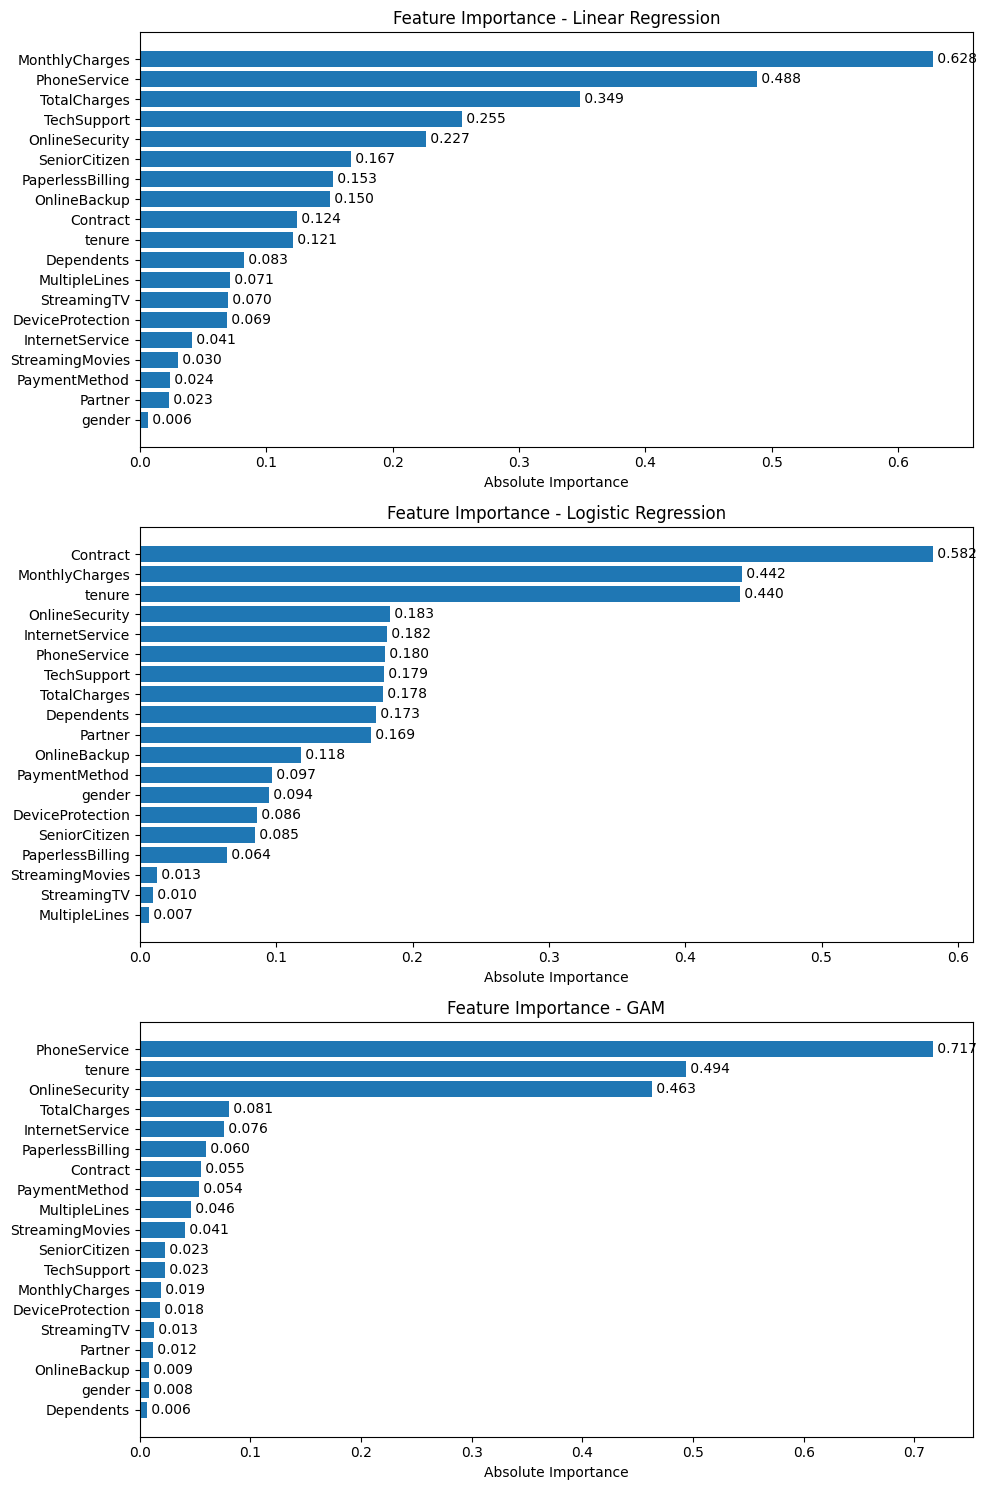

In [51]:
fig, axs = plt.subplots(len(models), 1, figsize=(10, 5*len(models)), squeeze=False)
for idx, (name, (model, _)) in enumerate(models.items()):
    ax = axs[idx, 0]
    
    if name in ['Linear Regression', 'Logistic Regression']:
        coefficients = model.coef
        importance = np.abs(coefficients)
    elif name == 'GAM':
        importance = gam.feature_importance()#np.array([np.sum(np.abs(coef)) for coef in model.coefs])

    # nomarlize
    importance = np.array(importance)
    importance = importance / np.linalg.norm(importance)
    
    # Sort features by importance
    sorted_idx = np.argsort(importance)
    pos = np.arange(len(features))
    ax.barh(pos, importance[sorted_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels([features[i] for i in sorted_idx])
    ax.set_xlabel('Absolute Importance')
    ax.set_title(f'Feature Importance - {name}')

    # Add value labels to the end of each bar
    for i, v in enumerate(importance[sorted_idx]):
        ax.text(v, i, f' {v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Model Analysis

### Pros and Cons for each model
    - Linear Regression
        - Pros: simple & interpretable
        - Cons:
            - can't model non-linear patterns
    - Logistic Regression
        - Pros:
            - provides probability estimates
            - good performance on binary classification
         
        - Cons:
            - can't model non-linear patterns  
    - GAM
        - Pros:
            - can model non-linear relationships
            - maintains interpretability
        - Cons:
            - needs careful hyperparameter tuning
            - maybe computationally expensive

### Recommendations for the company

In summary, I would like to recommand GAM model, which is a pretty efficient and intepretable model under the company's case. GAM could achieve a good balance between precision and recall(F1 score). The key is that GAM is able to capture non-linear variables, which means hidden factors that could affect the Churn. After understanding those potential factors, the company can prepare for next quarter quickly and efficiently. 